In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner
import datetime

# Import Training, Testing and Validating Set

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

In [3]:
# num of max poisoning points, max 20% poison rate
poison_ct = 328
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

Posion count:  328  Train count:  1319  Test count:  165  Proportion of poisoning:  0.19914996964177292


# Inverse Flip and Linear Reg Poisoner

classifier:  LinearRegression()


*****************************
**** Poison Count:  55  ****
*****************************
Iteration  0 
Objective Value:  0.007104663933184047  Change:  0.007104663933184047
Validation MSE  0.005536160108085639 
Test MSE  0.007719256587248782
 
Iteration  1
Objective Value: 0.004753207743718116  Difference:  -0.002351456189465931
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.004756769484508099  Difference:  -0.0023478944486759485
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.004759231704974153  Difference:  -0.0023454322282098943
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.004761000751195609  Difference:  -0.0023436631819884384
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.0047618261511541415  Difference:  -0.0023428377820299056
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.004762397698948967  Difference:  -0.00234226623423508
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.004762773156125941  Difference:  -0.00234189

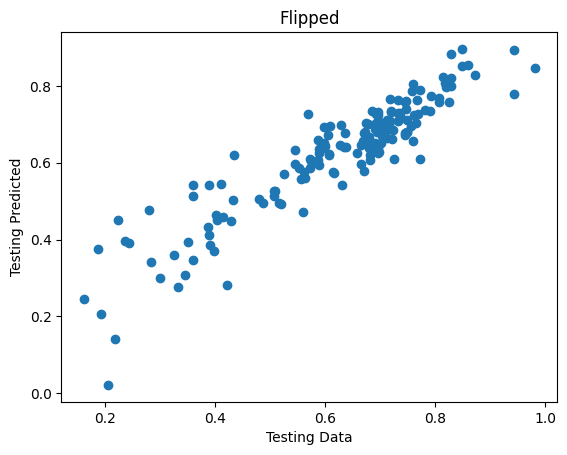

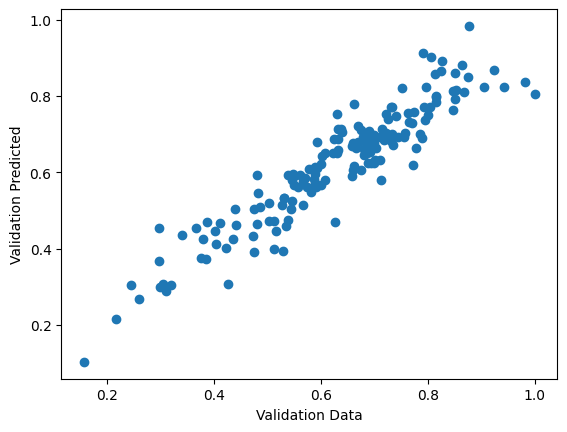

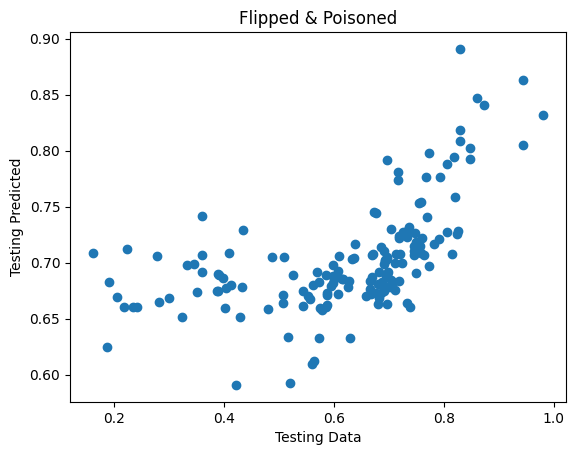

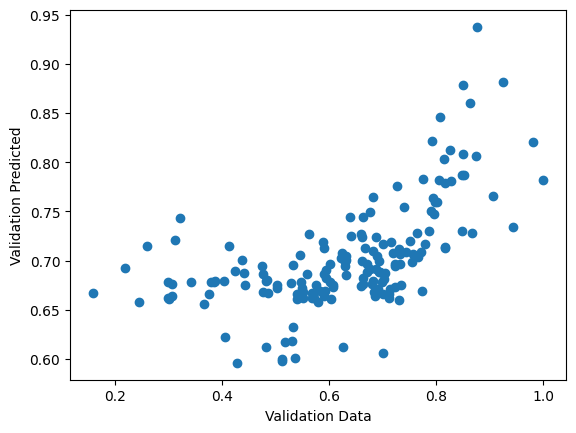


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.024522398667461115 
 Test MSE: 0.028226337854777683


In [4]:
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)
# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 5
stop2 = 20
stop3 = 10
decrease_rate = 0.65

poiser = gd_poisoner.linear_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier, False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    #print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# Perform B Flip and Linear Reg Poisoning

classifier:  LinearRegression()


*****************************
**** Poison Count:  55  ****
*****************************
Iteration  0 
Objective Value:  0.0054395233766863435  Change:  0.0054395233766863435
Validation MSE  0.004825450783431262 
Test MSE  0.005335916609995199
 
Iteration  1
Objective Value: 0.006611717598662024  Difference:  0.0011721942219756806
 
Iteration  2
Objective Value: 0.006611717598662024  Difference:  0.0
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.006611717598662024  Difference:  0.0
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.006611717598662024  Difference:  0.0
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.006611717598662024  Difference:  0.0
NO PROGRESS MADE!
 
Poisoned classifier:  LinearRegression() , 
Returned lambda:  0

Poison Proportion:  3.98 %

After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.005807329331016585 
 Test MSE: 0.

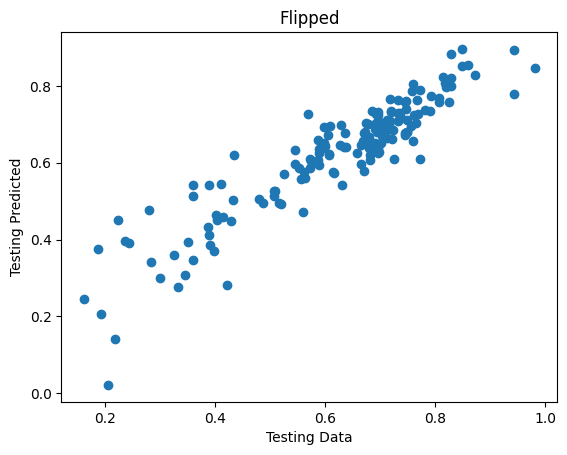

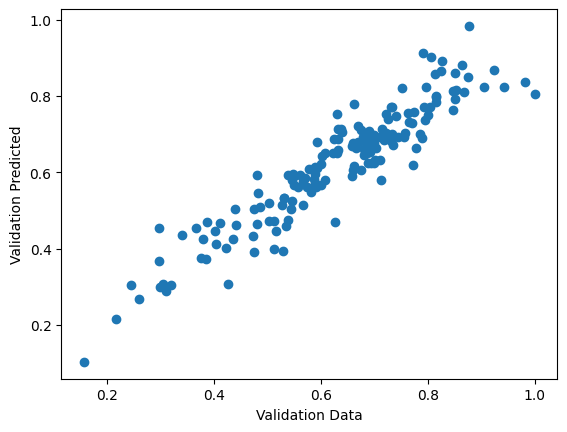

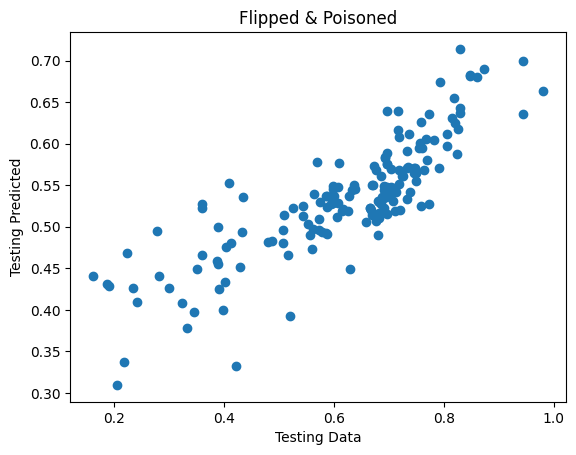

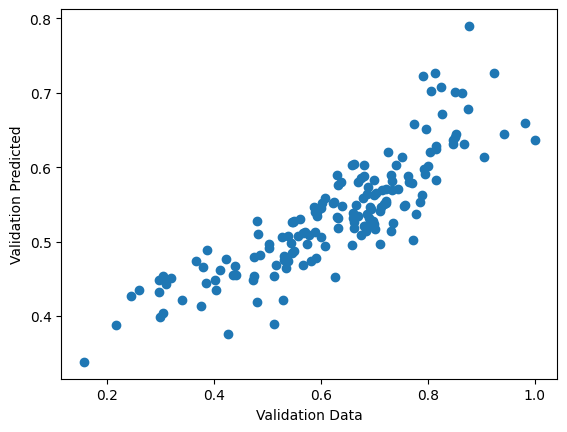


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.01934248942444041 
 Test MSE: 0.020906616148951066


In [5]:
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.linear_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier, False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
"""
Evaluate the poisoning attack with the poison rate of 4%, 8%, 12%, 16%, 20%
"""
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])